# Parte 2: Aprendizaje Semisupervisado para Clasificación de Rating

Este notebook implementa un protocolo de aprendizaje semisupervisado utilizando el dataset procesado, con baseline supervisado, Self-Training y Label Spreading/Propagation (k-NN). Incluye EDA, configuración experimental, evaluación con métricas solicitadas y análisis de hiperparámetros.

In [54]:
# Instalación de dependencias necesarias (ejecutar una vez)
import sys, subprocess
packages = [
    'numpy',
    'pandas',
    'matplotlib',
    'seaborn',
    'scikit-learn',
    'scipy'
]
subprocess.check_call([sys.executable, '-m', 'pip', 'install', '-q'] + packages)
print('Instalación de dependencias completada')

Instalación de dependencias completada


In [55]:
# Descarga y preparación del dataset
import os
import pandas as pd
from urllib.request import urlretrieve

# Crear directorios si no existen
os.makedirs('../data/processed', exist_ok=True)
dataset_path = '../data/processed/dataset.csv'

# Descargar el dataset si no existe
if not os.path.exists(dataset_path):
    print("Descargando dataset...")
    url = 'https://raw.githubusercontent.com/martin2000002/Proyecto-ML-202510-Data/main/dataset.csv'
    try:
        urlretrieve(url, dataset_path)
        print(f"Dataset descargado exitosamente en {dataset_path}")
    except Exception as e:
        print(f"Error al descargar el dataset: {e}")
        # Crear un DataFrame vacío para evitar errores en celdas posteriores
        pd.DataFrame().to_csv(dataset_path)
        print(f"Se ha creado un archivo CSV vacío en {dataset_path}")
else:
    print(f"El dataset ya existe en {dataset_path}")

El dataset ya existe en ../data/processed/dataset.csv


In [56]:
# Configuración general
import warnings
warnings.filterwarnings('ignore')

import os
import json
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, label_binarize
from sklearn.impute import SimpleImputer
from sklearn.pipeline import Pipeline
from sklearn.metrics import (f1_score, balanced_accuracy_score, confusion_matrix,
                             roc_curve, auc)
from sklearn.ensemble import RandomForestClassifier
from sklearn.feature_selection import VarianceThreshold
from sklearn.manifold import TSNE
from sklearn.semi_supervised import SelfTrainingClassifier, LabelSpreading, LabelPropagation

RANDOM_STATE = 42
np.random.seed(RANDOM_STATE)

DATA_PATH = os.path.join('..', 'data', 'processed', 'dataset.csv')
assert os.path.exists(DATA_PATH), f'No se encuentra el dataset en {DATA_PATH}'
df = pd.read_csv(DATA_PATH)
df.head()

,cooperativa,abreviacion,activos_productivos_sobre_total_activos,activos_productivos_sobre_pasivos_con_costo,morosidad_cartera_productiva,morosidad_total,cobertura_cartera_problematica,cartera_refinanciada,cartera_reestructurada,gastos_operativos_sobre_activos,roa,roe,cartera_sobre_depositos,margen_intermediacion_sobre_activo_promedio,label
0,15 DE ABRIL LTDA,15ABR,0.876898,1.027844,0.111285,0.107272,1.023424,0.144911,0.157736,0.055945,0.000585,0.005227,0.792486,-0.014466,BB
1,23 DE JULIO LIMITADA,23JUL,0.908252,1.044289,0.020040,0.093425,1.076982,0.162655,0.179990,0.043137,0.001484,0.013795,0.796689,-0.010111,A
2,29 DE OCTUBRE LTDA,29OCT,0.926584,1.039765,0.055395,0.099000,1.080869,0.146202,0.137274,0.029980,0.000520,0.005820,0.856153,-0.001481,AA
3,9 DE OCTUBRE LTDA,9OCT,0.921099,1.080646,0.000000,0.096313,0.963912,0.212391,0.249426,0.038264,0.000738,0.006256,0.822414,-0.004091,A
4,ALFONSO JARAMILLO LEON CAJA,AJL,0.905735,1.014125,0.080890,0.067223,1.019509,0.197214,0.164180,0.043149,0.001185,0.012872,0.871291,0.000183,BBB


## Estructura de datos y selección de variables
- Las columnas de identificación `cooperativa` y `abreviacion` no se usan como features.
- La columna de label es `Label`.
- Se asume que los demás campos numéricos están preprocesados.

In [57]:
# Definición de columnas y división X / y
id_cols = ['cooperativa', 'abreviacion']
label_col = 'label'
assert label_col in df.columns, 'No se encontró la columna de label esperada'
feature_cols = [c for c in df.columns if c not in id_cols + [label_col]]
X = df[feature_cols].copy()
y = df[label_col].astype(str).copy()
classes_ = np.unique(y)
n_classes = len(classes_)
X.shape, y.value_counts().to_dict()

((42, 12), {'AA': 15, 'A': 12, 'BBB': 12, 'BB': 1, 'AAA': 1, 'B': 1})

## EDA: Distribuciones, correlaciones y t-SNE
Exploramos la distribución de indicadores, correlaciones y redundancias, y visualizamos con t-SNE.

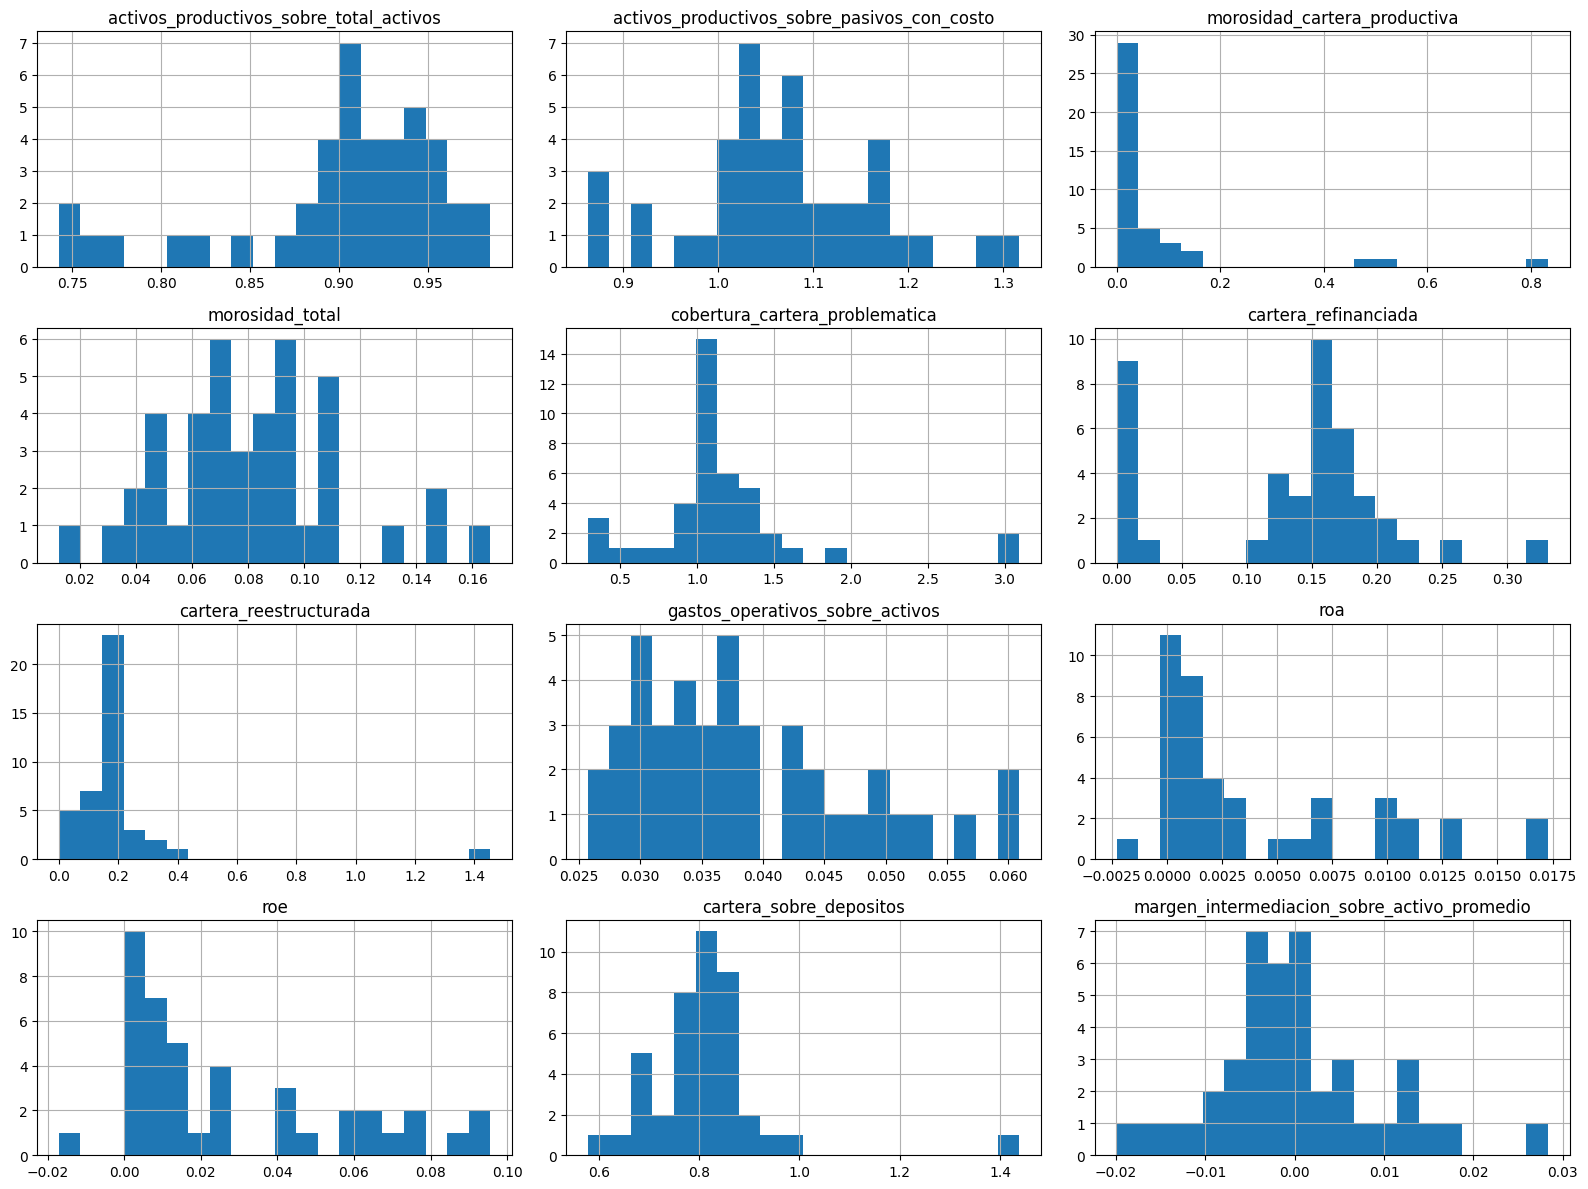

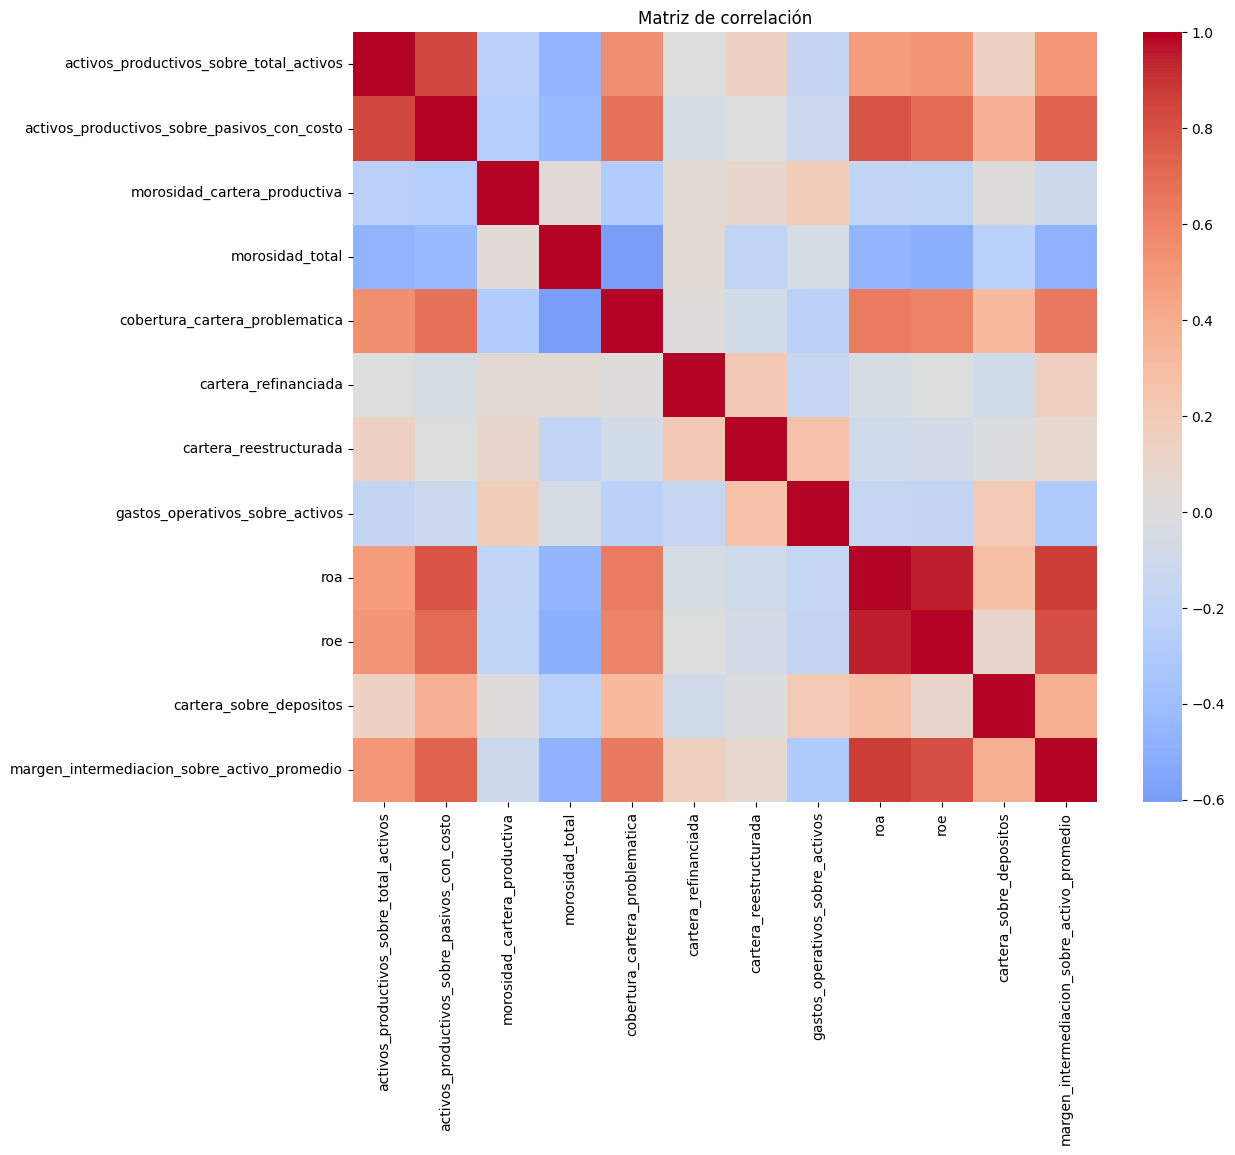

,feat1,feat2,corr
0,roa,roe,0.947008


In [58]:
# Distribución de indicadores (histogramas)
_ = X.hist(figsize=(16, 12), bins=20)
plt.tight_layout()
plt.show()

# Matriz de correlación
plt.figure(figsize=(12,10))
corr = X.corr(numeric_only=True)
sns.heatmap(corr, cmap='coolwarm', center=0)
plt.title('Matriz de correlación')
plt.show()

# Redundancias: pares con |corr| > 0.9
high_corr = []
thr = 0.9
for i, c1 in enumerate(feature_cols):
    for j, c2 in enumerate(feature_cols):
        if j <= i:
            continue
        val = corr.loc[c1, c2]
        if abs(val) > thr:
            high_corr.append((c1, c2, float(val)))
pd.DataFrame(high_corr, columns=['feat1','feat2','corr']).sort_values('corr', key=lambda s: s.abs(), ascending=False)


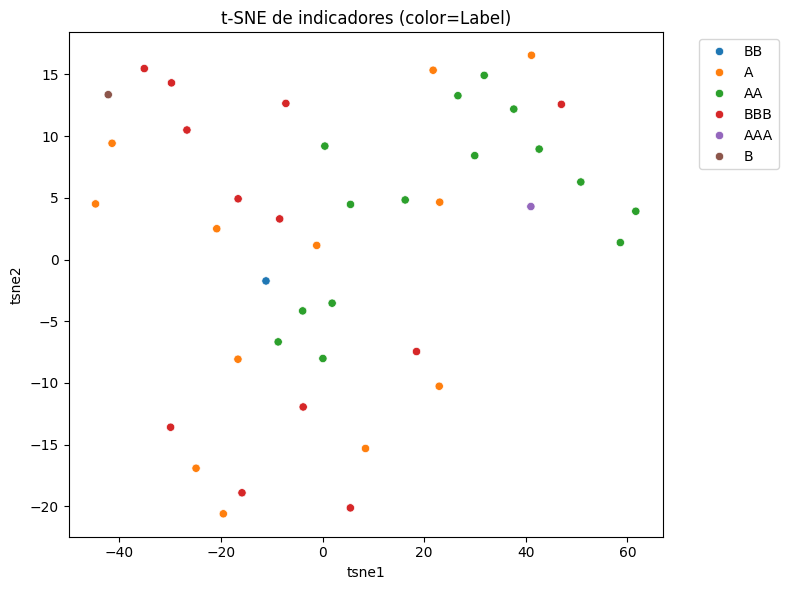

In [59]:
# t-SNE para visualización
tsne = TSNE(n_components=2, random_state=RANDOM_STATE, perplexity=int(np.clip(len(X)//5, 5, 30)))
emb = tsne.fit_transform(X)
emb_df = pd.DataFrame(emb, columns=['tsne1','tsne2'])
emb_df[label_col] = y.values
plt.figure(figsize=(8,6))
sns.scatterplot(data=emb_df, x='tsne1', y='tsne2', hue=label_col, palette='tab10')
plt.title('t-SNE de indicadores (color=Label)')
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
plt.tight_layout()
plt.show()


## 2.1 Configuración y protocolo
- `p ∈ {5%, 10%, 20%, 40%, 60%, 80%}` como fracción etiquetada en Train.
- 10 repeticiones por `p`.
- Preprocesamiento: imputación, escalado y filtro de varianza.
- Semilla fija para reproducibilidad.

In [60]:
import warnings
warnings.filterwarnings('ignore')

import os
import json
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, label_binarize
from sklearn.impute import SimpleImputer
from sklearn.pipeline import Pipeline
from sklearn.metrics import (f1_score, balanced_accuracy_score, confusion_matrix,
                             roc_curve, auc)
from sklearn.ensemble import RandomForestClassifier
from sklearn.feature_selection import VarianceThreshold
from sklearn.manifold import TSNE
from sklearn.semi_supervised import SelfTrainingClassifier, LabelSpreading, LabelPropagation

RANDOM_STATE = 42
np.random.seed(RANDOM_STATE)

DATA_PATH = os.path.join('..', 'data', 'processed', 'dataset.csv')
assert os.path.exists(DATA_PATH), f'No se encuentra el dataset en {DATA_PATH}'
df = pd.read_csv(DATA_PATH)

preprocess = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='median')),
    ('scaler', StandardScaler()),
    ('varth', VarianceThreshold(threshold=0.0))
])

def make_rf(random_state=RANDOM_STATE):
    return RandomForestClassifier(n_estimators=400, max_depth=None, n_jobs=-1, random_state=random_state)

def compute_metrics(y_true, y_pred, labels):
    f1_macro = f1_score(y_true, y_pred, average='macro', labels=labels)
    bal_acc = balanced_accuracy_score(y_true, y_pred)
    cm = confusion_matrix(y_true, y_pred, labels=labels)
    return f1_macro, bal_acc, cm

def compute_roc_auc(y_true, proba, classes, model_fitted_classes):
    """
    Computes macro-averaged ROC AUC, handling cases where the model
    might not have predicted all global classes.

    Args:
        y_true (array-like): True labels.
        proba (array-like): Predicted probabilities from the model.
                             Its columns correspond to model_fitted_classes.
        classes (array-like): All unique global class labels.
        model_fitted_classes (array-like): Classes the model was fitted on,
                                           in the order of proba columns.
    Returns:
        tuple: (roc_auc_per_class, macro_auc, fpr_per_class, tpr_per_class)
    """
    y_bin = label_binarize(y_true, classes=classes)

    # Initialize a probability array with zeros for all global classes
    proba_expanded = np.zeros((proba.shape[0], len(classes)))

    # Map model_fitted_classes to the global classes
    global_class_indices = []
    for mc in model_fitted_classes:
        if mc in classes: # Only consider classes that are part of the global class set
            global_class_indices.append(np.where(classes == mc)[0][0])
        # Else: if model_fitted_class is not in global classes (e.g., -1 for unlabeled), ignore it

    # Fill proba_expanded with the probabilities from 'proba'
    proba_col_idx = 0
    for global_idx in global_class_indices:
        if proba_col_idx < proba.shape[1]: # Ensure we don't go out of bounds for proba
            proba_expanded[:, global_idx] = proba[:, proba_col_idx]
            proba_col_idx += 1
        else:
            break # No more columns in proba to map

    fpr = {}; tpr = {}; roc_auc = {}
    from numpy import trapz # Import trapz here to ensure it's available

    for i, c in enumerate(classes):
        # Only compute ROC if the class is actually present in y_true
        # AND has corresponding predicted probabilities (non-zero sum in the expanded column)
        # AND there are no NaNs in the probabilities for this class
        if np.sum(y_bin[:, i]) > 0 and np.sum(proba_expanded[:, i]) > 0 and not np.isnan(proba_expanded[:, i]).any():
            fpr[c], tpr[c], _ = roc_curve(y_bin[:, i], proba_expanded[:, i])
            roc_auc[c] = trapz(tpr[c], fpr[c])
        else:
            # If a class is not present in y_true, has no predicted prob, or has NaNs in proba,
            # set default ROC curve and AUC to NaN (not computable)
            fpr[c], tpr[c] = np.array([0., 1.]), np.array([0., 1.])
            roc_auc[c] = np.nan

    all_fpr = np.unique(np.concatenate([fpr[c] for c in classes]))
    mean_tpr = np.zeros_like(all_fpr)

    valid_classes_for_auc = [c for c in classes if not np.isnan(roc_auc[c])]

    if len(valid_classes_for_auc) > 0:
        for c in valid_classes_for_auc:
            # Only interpolate for valid classes, where FPR/TPR were computed
            if c in fpr and c in tpr: # defensive check
                mean_tpr += np.interp(all_fpr, fpr[c], tpr[c])
        mean_tpr /= len(valid_classes_for_auc)
        macro_auc = trapz(mean_tpr, all_fpr)
    else:
        macro_auc = np.nan # If no valid classes, macro AUC is not computable

    return roc_auc, macro_auc, fpr, tpr


## 2.2 Modelos: Baseline y Semisupervisados
- Baseline: Random Forest entrenado solo con la porción etiquetada.
- Self-Training: RF base con umbral de confianza `τ`.
- Label Spreading/Propagation: kernel `knn` con `k` vecinos (distancia euclidiana tras escalado).

In [61]:
from copy import deepcopy

def fit_predict_baseline(X_l, y_l, X_te):
    pipe = Pipeline(steps=[('prep', preprocess), ('clf', make_rf())])
    pipe.fit(X_l, y_l)
    y_pred = pipe.predict(X_te)
    proba = pipe.predict_proba(X_te) if hasattr(pipe.named_steps['clf'], 'predict_proba') else None
    return y_pred, proba, pipe

def fit_predict_self_training(X_tr, y_tr_with_unlabeled, X_te, threshold):
    base = make_rf()
    st = SelfTrainingClassifier(base_estimator=base, threshold=threshold, verbose=False)
    pipe = Pipeline(steps=[('prep', preprocess), ('clf', st)])
    pipe.fit(X_tr, y_tr_with_unlabeled)
    y_pred = pipe.predict(X_te)
    proba = None
    try:
        proba = pipe.predict_proba(X_te)
    except Exception:
        pass
    return y_pred, proba, pipe

def fit_predict_label_graph(X_tr, y_tr_with_unlabeled, X_te, method='spreading', k=10):
    if method == 'spreading':
        lg = LabelSpreading(kernel='knn', n_neighbors=int(k), alpha=0.2)
    else:
        lg = LabelPropagation(kernel='knn', n_neighbors=int(k))
    # Escalado para kNN
    scaler = Pipeline([('imputer', SimpleImputer(strategy='median')), ('scaler', StandardScaler())])
    X_tr_s = scaler.fit_transform(X_tr)

    # Codificación de labels: mantener -1 como no etiquetado, mapear etiquetas reales a enteros
    y_arr = np.asarray(y_tr_with_unlabeled)
    unlabeled_mask = (y_arr == -1) | (y_arr == '-1')
    labeled_vals = y_arr[~unlabeled_mask]
    # Si no hay etiquetas, devolver predicción trivial
    if labeled_vals.size == 0:
        # Predecimos por mayoría de y_train si existiera, aquí devolvemos baseline simple (clase más frecuente en y_tr)
        # Como fallback, retornamos todo como la primera clase de y si existe
        raise ValueError('No hay muestras etiquetadas para construir el grafo (LabelSpreading/Propagation).')

    orig_classes = np.unique(labeled_vals)
    cls_to_int = {c: i for i, c in enumerate(orig_classes)}
    y_enc = np.full(shape=y_arr.shape, fill_value=-1, dtype=int)
    for i, v in enumerate(y_arr):
        if i < y_enc.shape[0] and not ((v == -1) or (v == '-1')):
            y_enc[i] = cls_to_int[v]

    # Fit
    lg.fit(X_tr_s, y_enc)
    # Guardar clases originales en el modelo y mantener el mismo orden que en la codificación
    try:
        lg.classes_ = orig_classes
    except Exception:
        pass

    # Predict
    X_te_s = scaler.transform(X_te)
    y_pred_int = lg.predict(X_te_s)

    # Mapear de vuelta a etiquetas originales
    int_to_cls = {i: c for c, i in cls_to_int.items()}
    y_pred = np.array([int_to_cls.get(i, orig_classes[0]) for i in y_pred_int])

    proba = None
    try:
        proba = lg.predict_proba(X_te_s)
    except Exception:
        pass

    return y_pred, proba, lg

## 2.3 Protocolo de validación y corridas
Split Train/Test (20% test). Para cada `p` y repetición, muestreo estratificado etiquetado dentro de Train; el resto se trata como no etiquetado.

In [63]:
# División base Train/Test y protocolo con manejo robusto de clases raras y AUC sin NaN
# - Si alguna clase tiene <2 muestras, evitamos estratificación en el split base.
# - En cada repetición, garantizamos al menos 2 muestras etiquetadas para el baseline.
# - Cálculo de AUC macro alineando clases del modelo y del test, filtrando NaN y casos degenerados.

test_size = 0.2
min_class = y.value_counts().min()
if min_class < 2:
    X_train, X_test, y_train, y_test = train_test_split(
        X, y, test_size=test_size, shuffle=True, random_state=RANDOM_STATE
    )
else:
    X_train, X_test, y_train, y_test = train_test_split(
        X, y, test_size=test_size, stratify=y, random_state=RANDOM_STATE
    )

# Configuración experimental
ratios = [0.05, 0.10, 0.20, 0.40, 0.60, 0.80]
repeats = 10
taus = [0.6, 0.7, 0.8, 0.9]
knns = [5, 10, 20]

results = []

# Utilidad: AUC macro seguro ante NaNs y clases faltantes
from sklearn.preprocessing import label_binarize
from sklearn.metrics import roc_curve
import numpy as np

def auc_macro_safe(y_true, proba, model_classes, all_classes):
    """Alinea probabilidades a clases comunes, filtra NaNs y calcula macro AUC.
    Devuelve None si no hay al menos 1 clase válida para el cálculo.
    """
    # Clases presentes en modelo y en y_true
    commons = [c for c in all_classes if (c in model_classes) and (c in y_true.values)]
    if len(commons) == 0:
        return None
    # Ajuste binario especial cuando el modelo devuelve una única probabilidad
    aligned_proba = proba
    if len(model_classes) == 2 and proba is not None and proba.shape[1] == 1:
        p_pos = proba[:, 0]
        aligned_proba = np.column_stack([1 - p_pos, p_pos])
    # Mapa de índices de clases
    idx_map = {c: list(model_classes).index(c) for c in commons}
    proba_aligned = np.column_stack([aligned_proba[:, idx_map[c]] for c in commons])
    # Binarización de y_true en el mismo orden de commons
    y_bin = label_binarize(y_true, classes=commons)
    if y_bin.ndim == 1:
        y_bin = y_bin.reshape(-1, 1)
    # Caso binario con una sola columna -> expandir a 2 columnas tipo one-vs-rest
    if y_bin.shape[1] == 1 and len(commons) == 2:
        y_bin = np.column_stack([1 - y_bin[:, 0], y_bin[:, 0]])
        proba_aligned = proba_aligned[:, :2]
    # Calcular AUC por clase filtrando NaNs y casos sin positivos/negativos
    aucs = []
    for i, c in enumerate(commons):
        y_i = y_bin[:, i]
        p_i = proba_aligned[:, i]
        # Filtro de NaNs
        mask = ~np.isnan(y_i) & ~np.isnan(p_i)
        y_i = y_i[mask]
        p_i = p_i[mask]
        # Necesita al menos un positivo y un negativo
        if y_i.size == 0 or np.all(y_i == 0) or np.all(y_i == 1):
            continue
        fpr, tpr, _ = roc_curve(y_i, p_i)
        aucs.append(np.trapz(tpr, fpr))
    if len(aucs) == 0:
        return None
    return float(np.mean(aucs))

for p in ratios:
    for rep in range(repeats):
        rs = RANDOM_STATE + rep + int(p * 1000)
        X_tr, y_tr = X_train.copy(), y_train.copy()

        # Asegurar al menos 2 muestras etiquetadas para evitar fallos en el pipeline (e.g., VarThreshold)
        num_samples_for_X_l = int(len(X_tr) * p)
        effective_train_size_for_X_l = p if num_samples_for_X_l >= 2 else min(2, len(X_tr))

        # Muestreo etiquetado (estratificado si es viable)
        if y_tr.value_counts().min() < 2:
            X_l, _, y_l, _ = train_test_split(
                X_tr, y_tr,
                train_size=effective_train_size_for_X_l,
                shuffle=True,
                random_state=rs
            )
        else:
            X_l, _, y_l, _ = train_test_split(
                X_tr, y_tr,
                train_size=effective_train_size_for_X_l,
                stratify=y_tr,
                random_state=rs
            )

        # Construcción de etiquetas semisupervisadas: -1 para no etiquetados
        y_tr_semi = pd.Series(-1, index=X_tr.index)
        y_tr_semi.loc[y_l.index] = y_l.values

        # Baseline
        yb_pred, yb_proba, pipe_baseline = fit_predict_baseline(X_l, y_l, X_test)
        b_f1, b_bal, _ = compute_metrics(y_test, yb_pred, classes_)

        b_auc_macro = None
        if yb_proba is not None:
            model_classes = pipe_baseline.named_steps['clf'].classes_
            b_auc_macro = auc_macro_safe(y_test, yb_proba, model_classes, classes_)

        results.append({
            'p': p,
            'rep': rep,
            'method': 'baseline',
            'param': None,
            'f1_macro': b_f1,
            'bal_acc': b_bal,
            'auc_macro': b_auc_macro
        })

        # Self-Training
        for tau in taus:
            ys_pred, ys_proba, pipe_st = fit_predict_self_training(
                X_tr, y_tr_semi.values, X_test, threshold=tau
            )
            s_f1, s_bal, _ = compute_metrics(y_test, ys_pred, classes_)
            s_auc_macro = None
            if ys_proba is not None:
                model_classes = pipe_st.named_steps['clf'].classes_
                s_auc_macro = auc_macro_safe(y_test, ys_proba, model_classes, classes_)

            results.append({
                'p': p,
                'rep': rep,
                'method': 'self_training',
                'param': {'tau': tau},
                'f1_macro': s_f1,
                'bal_acc': s_bal,
                'auc_macro': s_auc_macro,
                'delta_f1': s_f1 - b_f1,
                'delta_bal': s_bal - b_bal
            })

        # =======================
        # Label Spreading / Propagation
        # =======================
        for k in knns:
            for meth in ['spreading', 'propagation']:
                yl_pred, yl_proba, lg_model = fit_predict_label_graph(
                    X_tr, y_tr_semi.values, X_test, method=meth, k=k
                )
                l_f1, l_bal, _ = compute_metrics(y_test, yl_pred, classes_)
                l_auc_macro = None
                if yl_proba is not None:
                    model_classes = lg_model.classes_
                    l_auc_macro = auc_macro_safe(y_test, yl_proba, model_classes, classes_)

                results.append({
                    'p': p,
                    'rep': rep,
                    'method': f'label_{meth}',
                    'param': {'k': k},
                    'f1_macro': l_f1,
                    'bal_acc': l_bal,
                    'auc_macro': l_auc_macro,
                    'delta_f1': l_f1 - b_f1,
                    'delta_bal': l_bal - b_bal
                })

# Resultados agregados de la corrida
results_df = pd.DataFrame(results)
results_df.head()

,p,rep,method,param,f1_macro,bal_acc,auc_macro,delta_f1,delta_bal
0,0.05,0,baseline,None,0.119048,0.5,NaN,NaN,NaN
1,0.05,0,self_training,{'tau': 0.6},0.119048,0.5,NaN,0.0,0.0
2,0.05,0,self_training,{'tau': 0.7},0.119048,0.5,NaN,0.0,0.0
3,0.05,0,self_training,{'tau': 0.8},0.119048,0.5,NaN,0.0,0.0
4,0.05,0,self_training,{'tau': 0.9},0.119048,0.5,NaN,0.0,0.0


## 2.3 Métricas de evaluación y comparación vs baseline
- Macro F1, Balanced Accuracy, ROC-AUC (macro).
- Ganancia vs baseline: ΔMacro-F1 y ΔBalanced-Acc.
- Matriz de confusión por `p` (promedio sobre repeticiones).

In [64]:
# Resumen por método y p
agg = results_df.groupby(['method','p']).agg(
    f1_macro_mean=('f1_macro','mean'), f1_macro_std=('f1_macro','std'),
    bal_acc_mean=('bal_acc','mean'), bal_acc_std=('bal_acc','std'),
    auc_macro_mean=('auc_macro','mean')
).reset_index()
agg.sort_values(['method','p'])


,method,p,f1_macro_mean,f1_macro_std,bal_acc_mean,bal_acc_std,auc_macro_mean
0,baseline,0.05,0.104899,0.078874,0.350000,0.267706,0.900000
1,baseline,0.10,0.126028,0.108374,0.370000,0.333292,0.975000
2,baseline,0.20,0.105790,0.114484,0.300000,0.327872,0.778125
3,baseline,0.40,0.238688,0.069927,0.677500,0.225909,0.951250
4,baseline,0.60,0.220582,0.062812,0.565000,0.184917,0.915000
5,baseline,0.80,0.233796,0.056666,0.602500,0.152957,0.948750
6,label_propagation,0.05,0.045971,0.057449,0.200000,0.249136,0.650000
7,label_propagation,0.10,0.035714,0.055487,0.150000,0.233046,0.836111
8,label_propagation,0.20,0.000000,0.000000,0.000000,0.000000,0.650521
9,label_propagation,0.40,0.000000,0.000000,0.000000,0.000000,0.776667


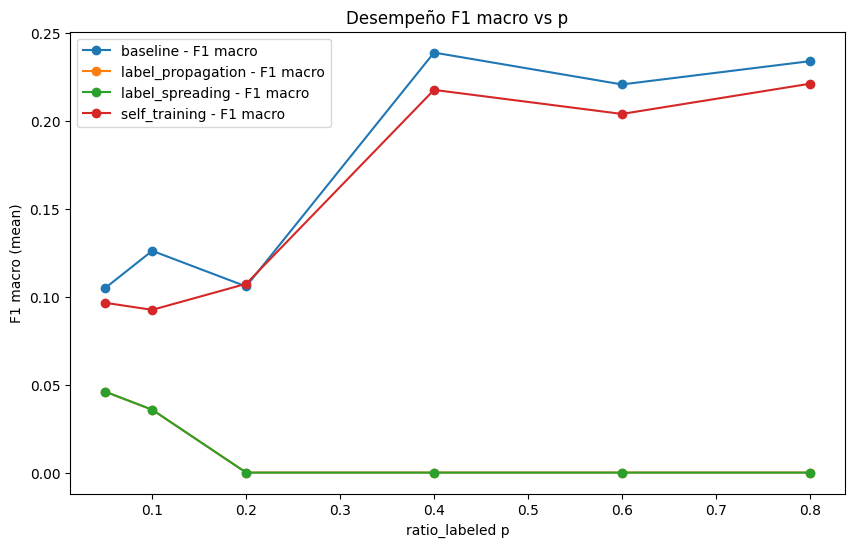

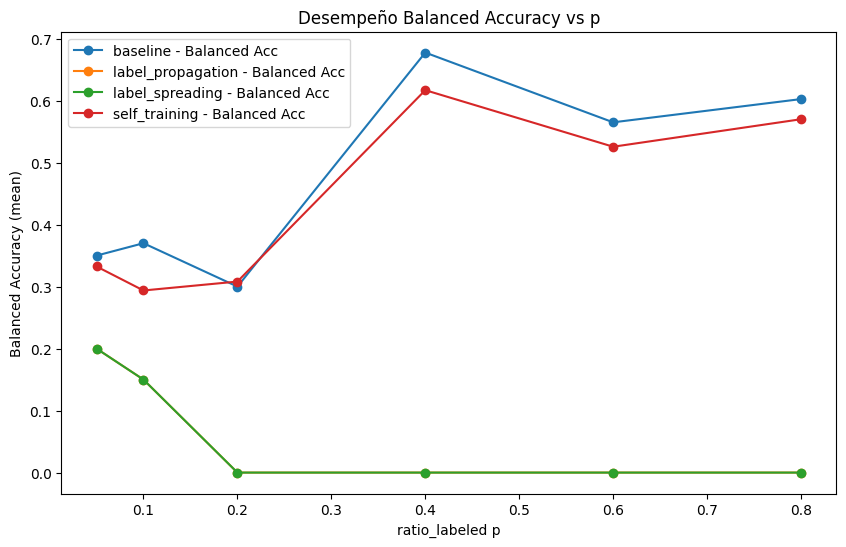

In [65]:
# Curvas desempeño vs ratio_labeled p
plt.figure(figsize=(10,6))
for m in agg['method'].unique():
    sub = agg[agg['method']==m]
    plt.plot(sub['p'], sub['f1_macro_mean'], marker='o', label=f'{m} - F1 macro')
plt.xlabel('ratio_labeled p')
plt.ylabel('F1 macro (mean)')
plt.title('Desempeño F1 macro vs p')
plt.legend()
plt.show()

plt.figure(figsize=(10,6))
for m in agg['method'].unique():
    sub = agg[agg['method']==m]
    plt.plot(sub['p'], sub['bal_acc_mean'], marker='o', label=f'{m} - Balanced Acc')
plt.xlabel('ratio_labeled p')
plt.ylabel('Balanced Accuracy (mean)')
plt.title('Desempeño Balanced Accuracy vs p')
plt.legend()
plt.show()


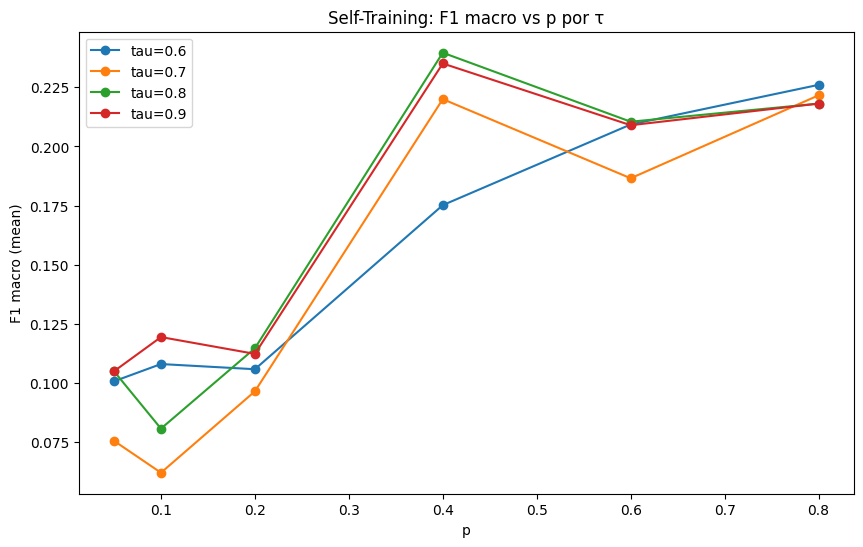

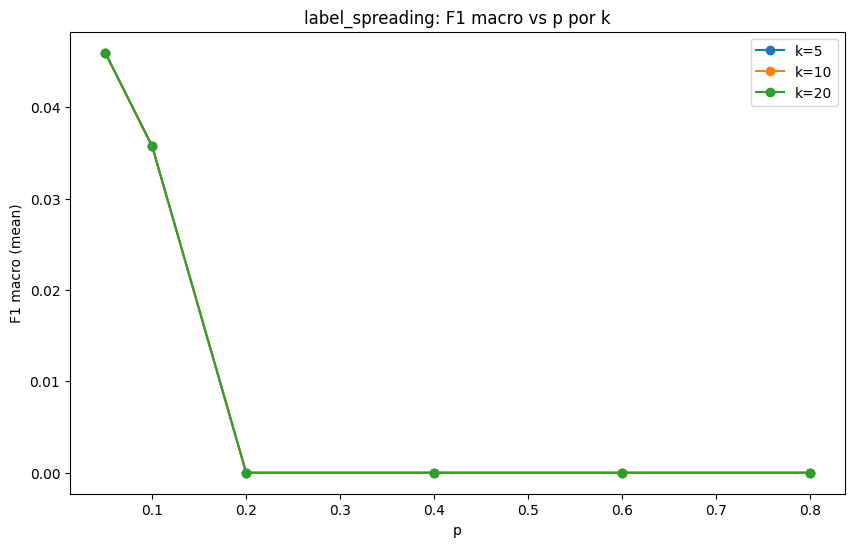

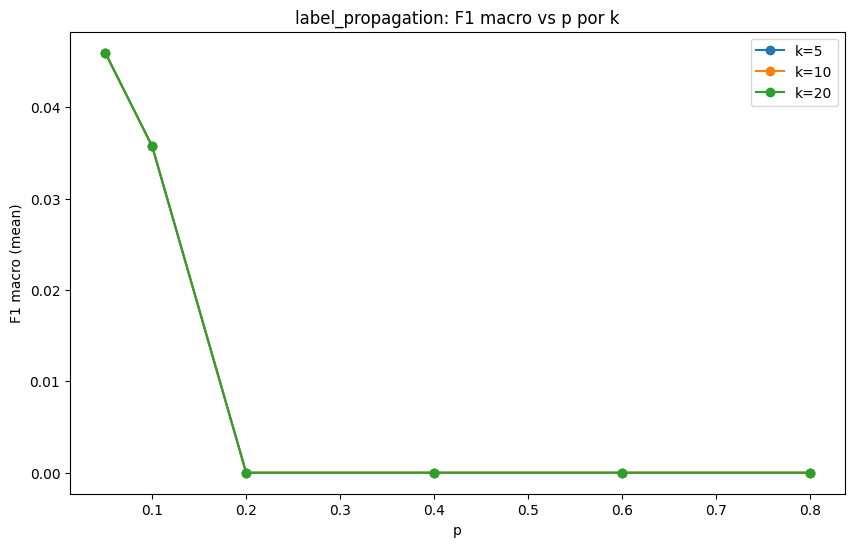

In [66]:
# Efecto de τ en Self-Training y de k en Label Graph
st_sub = results_df[results_df['method']=='self_training']
if not st_sub.empty:
    st_sub = st_sub.copy()
    st_sub['tau'] = st_sub['param'].apply(lambda d: d.get('tau') if isinstance(d, dict) else None)
    plt.figure(figsize=(10,6))
    for tau in sorted([t for t in st_sub['tau'].dropna().unique()]):
        tmp = st_sub[st_sub['tau']==tau].groupby('p').agg(f1=('f1_macro','mean')).reset_index()
        plt.plot(tmp['p'], tmp['f1'], marker='o', label=f'tau={tau}')
    plt.title('Self-Training: F1 macro vs p por τ')
    plt.xlabel('p')
    plt.ylabel('F1 macro (mean)')
    plt.legend()
    plt.show()

for meth in ['label_spreading','label_propagation']:
    lg_sub = results_df[results_df['method']==meth]
    if lg_sub.empty:
        continue
    lg_sub = lg_sub.copy()
    lg_sub['k'] = lg_sub['param'].apply(lambda d: d.get('k') if isinstance(d, dict) else None)
    plt.figure(figsize=(10,6))
    for k in sorted([int(v) for v in lg_sub['k'].dropna().unique()]):
        tmp = lg_sub[lg_sub['k']==k].groupby('p').agg(f1=('f1_macro','mean')).reset_index()
        plt.plot(tmp['p'], tmp['f1'], marker='o', label=f'k={k}')
    plt.title(f'{meth}: F1 macro vs p por k')
    plt.xlabel('p')
    plt.ylabel('F1 macro (mean)')
    plt.legend()
    plt.show()


In [67]:
# Ganancia vs baseline (Δ) para cada método
base = results_df[results_df['method']=='baseline'][['p','rep','f1_macro','bal_acc']].rename(columns={'f1_macro':'b_f1','bal_acc':'b_bal'})
merged = results_df.merge(base, on=['p','rep'], how='left')
merged['delta_f1_calc'] = merged['f1_macro'] - merged['b_f1']
merged['delta_bal_calc'] = merged['bal_acc'] - merged['b_bal']
gain = merged[merged['method']!='baseline'].groupby(['method','p']).agg(
    dF1_mean=('delta_f1_calc','mean'), dF1_std=('delta_f1_calc','std'),
    dBal_mean=('delta_bal_calc','mean'), dBal_std=('delta_bal_calc','std')
).reset_index()
gain.sort_values(['method','p'])


,method,p,dF1_mean,dF1_std,dBal_mean,dBal_std
0,label_propagation,0.05,-0.058929,0.061080,-0.150000,0.159201
1,label_propagation,0.10,-0.090313,0.068991,-0.220000,0.192913
2,label_propagation,0.20,-0.105790,0.110466,-0.300000,0.316364
3,label_propagation,0.40,-0.238688,0.067472,-0.677500,0.217980
4,label_propagation,0.60,-0.220582,0.060607,-0.565000,0.178427
5,label_propagation,0.80,-0.233796,0.054677,-0.602500,0.147588
6,label_spreading,0.05,-0.058929,0.061080,-0.150000,0.159201
7,label_spreading,0.10,-0.090313,0.068991,-0.220000,0.192913
8,label_spreading,0.20,-0.105790,0.110466,-0.300000,0.316364
9,label_spreading,0.40,-0.238688,0.067472,-0.677500,0.217980


In [69]:
# Test estadístico vs baseline (t-test pareado por p)
# - Compara F1 macro de cada método vs baseline por p.
# - Maneja el caso sin suficiente data (listas vacías o tamaños desiguales).
from scipy.stats import ttest_rel

tests = []
for p in ratios:
    base_scores = results_df[(results_df['method']=='baseline') & (results_df['p']==p)]['f1_macro'].values
    for meth in results_df['method'].unique():
        if meth=='baseline':
            continue
        meth_scores = results_df[(results_df['method']==meth) & (results_df['p']==p)]['f1_macro'].values
        # Requiere mismas corridas y al menos 2 pares para t-test pareado
        if len(base_scores)==len(meth_scores) and len(base_scores) > 1:
            t, pval = ttest_rel(meth_scores, base_scores)
            tests.append({'p': p, 'method': meth, 't_stat': t, 'p_value': pval})

# Construcción segura del DataFrame y ordenamiento
if len(tests) == 0:
    tests_df = pd.DataFrame(columns=['p','method','t_stat','p_value'])
else:
    tests_df = pd.DataFrame(tests)
    sort_cols = [c for c in ['method','p'] if c in tests_df.columns]
    if sort_cols:
        tests_df = tests_df.sort_values(sort_cols)

tests_df

,p,method,t_stat,p_value


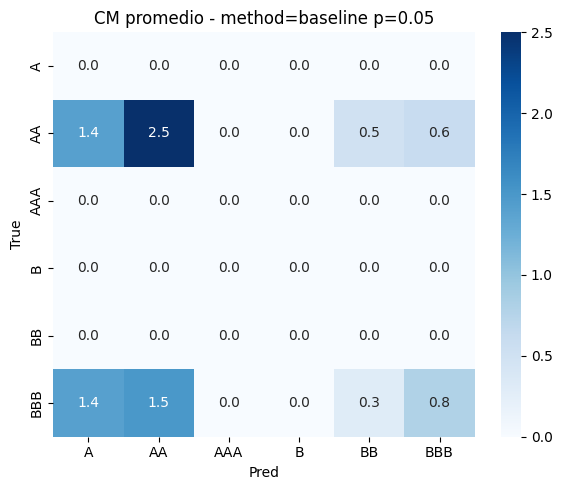

In [71]:
# Matrices de confusión promedio por p y método (ejemplo de visualización)
cm_summary = []
for p in ratios:
    for meth in results_df['method'].unique():
        cms = []
        for rep in range(repeats):
            rs = RANDOM_STATE + rep + int(p*1000)
            X_tr, y_tr = X_train.copy(), y_train.copy()

            # Asegurar al menos 2 muestras etiquetadas y evitar estratificación si hay clases con <2 muestras
            num_samples_for_X_l = int(len(X_tr) * p)
            effective_train_size_for_X_l = p if num_samples_for_X_l >= 2 else min(2, len(X_tr))

            if y_tr.value_counts().min() < 2:
                X_l, _, y_l, _ = train_test_split(
                    X_tr, y_tr,
                    train_size=effective_train_size_for_X_l,
                    shuffle=True,
                    random_state=rs
                )
            else:
                X_l, _, y_l, _ = train_test_split(
                    X_tr, y_tr,
                    train_size=effective_train_size_for_X_l,
                    stratify=y_tr,
                    random_state=rs
                )

            y_tr_semi = pd.Series(-1, index=X_tr.index)
            y_tr_semi.loc[y_l.index] = y_l.values

            if meth=='baseline':
                y_pred, _, _ = fit_predict_baseline(X_l, y_l, X_test)
            elif meth=='self_training':
                tau = float(np.median(taus))
                y_pred, _, _ = fit_predict_self_training(X_tr, y_tr_semi.values, X_test, threshold=tau)
            elif meth in ['label_spreading','label_propagation']:
                k = 10
                y_pred, _, _ = fit_predict_label_graph(X_tr, y_tr_semi.values, X_test, method=meth.split('_')[1], k=int(k))
            else:
                continue
            cm = confusion_matrix(y_test, y_pred, labels=classes_)
            cms.append(cm)
        if cms:
            cm_mean = np.mean(cms, axis=0)
            cm_summary.append({'p': p, 'method': meth, 'cm_mean': cm_mean})

# Mostrar un ejemplo
if cm_summary:
    ex = cm_summary[0]
    plt.figure(figsize=(6,5))
    sns.heatmap(ex['cm_mean'], annot=True, fmt='.1f', xticklabels=classes_, yticklabels=classes_, cmap='Blues')
    plt.title(f"CM promedio - method={ex['method']} p={ex['p']}")
    plt.ylabel('True')
    plt.xlabel('Pred')
    plt.tight_layout()
    plt.show()

## ROC y AUC (ejemplo de corrida)
Se grafican curvas ROC macro para baseline y un método semisupervisado representativo (mejor F1 macro promedio).

In [72]:
semi_methods = results_df[results_df['method']!='baseline'].groupby('method').agg(mean_f1=('f1_macro','mean')).sort_values('mean_f1', ascending=False)
best_method = semi_methods.index[0] if len(semi_methods)>0 else None
best_method


'self_training'

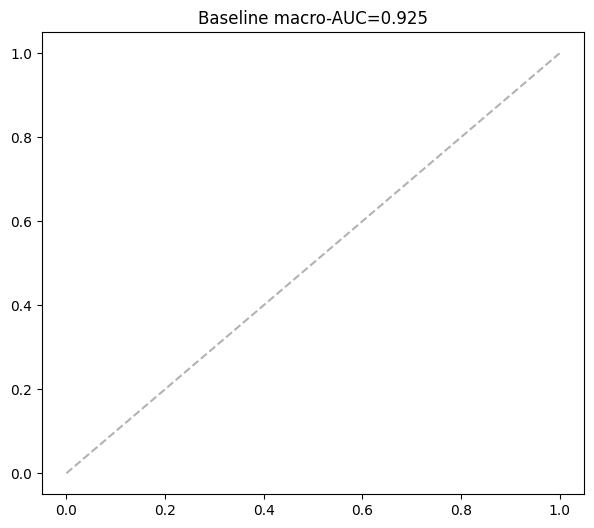

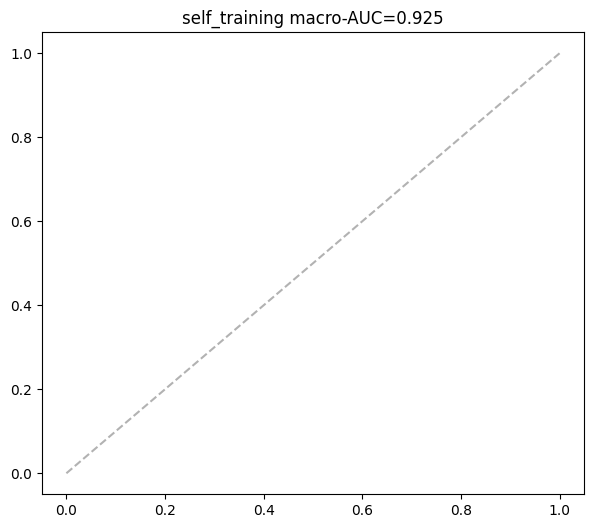

In [74]:
# Curvas ROC en la última corrida del mejor método (split robusto y AUC seguro)
if best_method is not None:
    last = results_df[results_df['method']==best_method].iloc[-1]
    p = last['p']; rep = int(last['rep'])
    rs = RANDOM_STATE + rep + int(p*1000)
    X_tr, y_tr = X_train.copy(), y_train.copy()

    # Asegurar al menos 2 muestras etiquetadas y evitar estratificación si hay clases con <2 muestras
    num_samples_for_X_l = int(len(X_tr) * p)
    effective_train_size_for_X_l = p if num_samples_for_X_l >= 2 else min(2, len(X_tr))

    if y_tr.value_counts().min() < 2:
        X_l, _, y_l, _ = train_test_split(
            X_tr, y_tr,
            train_size=effective_train_size_for_X_l,
            shuffle=True,
            random_state=rs
        )
    else:
        X_l, _, y_l, _ = train_test_split(
            X_tr, y_tr,
            train_size=effective_train_size_for_X_l,
            stratify=y_tr,
            random_state=rs
        )

    y_tr_semi = pd.Series(-1, index=X_tr.index)
    y_tr_semi.loc[y_l.index] = y_l.values

    # Baseline proba
    _, b_proba, pipe_b = fit_predict_baseline(X_l, y_l, X_test)

    # Proba del mejor método
    proba_semi = None
    if best_method=='self_training':
        tau = results_df[(results_df['method']=='self_training') & (results_df['p']==p)]['param'].iloc[-1]['tau']
        _, proba_semi, _ = fit_predict_self_training(X_tr, y_tr_semi.values, X_test, threshold=tau)
    elif best_method in ['label_spreading','label_propagation']:
        k = results_df[(results_df['method']==best_method) & (results_df['p']==p)]['param'].iloc[-1]['k']
        _, proba_semi, lg_model = fit_predict_label_graph(X_tr, y_tr_semi.values, X_test, method=best_method.split('_')[1], k=k)

    # AUC macro seguro (clases comunes y sin NaNs)
    b_auc_macro = None
    if b_proba is not None:
        model_classes_b = pipe_b.named_steps['clf'].classes_
        b_auc_macro = auc_macro_safe(y_test, b_proba, model_classes_b, classes_)
        plt.figure(figsize=(7,6))
        plt.plot([0,1],[0,1],'k--',alpha=0.3)
        plt.title(f'Baseline macro-AUC={b_auc_macro if b_auc_macro is not None else float("nan"):.3f}')
        plt.show()

    if proba_semi is not None:
        # Determinar clases del modelo semisupervisado
        if best_method=='self_training':
            # SelfTraining envuelve un estimador con .classes_
            model_classes_s = pipe_b.named_steps['clf'].classes_ if hasattr(pipe_b.named_steps['clf'], 'classes_') else classes_
        else:
            # Label graph ya fijó classes_ en el modelo devuelto
            model_classes_s = lg_model.classes_ if 'lg_model' in locals() else classes_
        s_auc_macro = auc_macro_safe(y_test, proba_semi, model_classes_s, classes_)
        plt.figure(figsize=(7,6))
        plt.plot([0,1],[0,1],'k--',alpha=0.3)
        plt.title(f'{best_method} macro-AUC={s_auc_macro if s_auc_macro is not None else float("nan"):.3f}')
        plt.show()

## Interpretabilidad: Importancia de variables (RF) y t-SNE coloreado por label

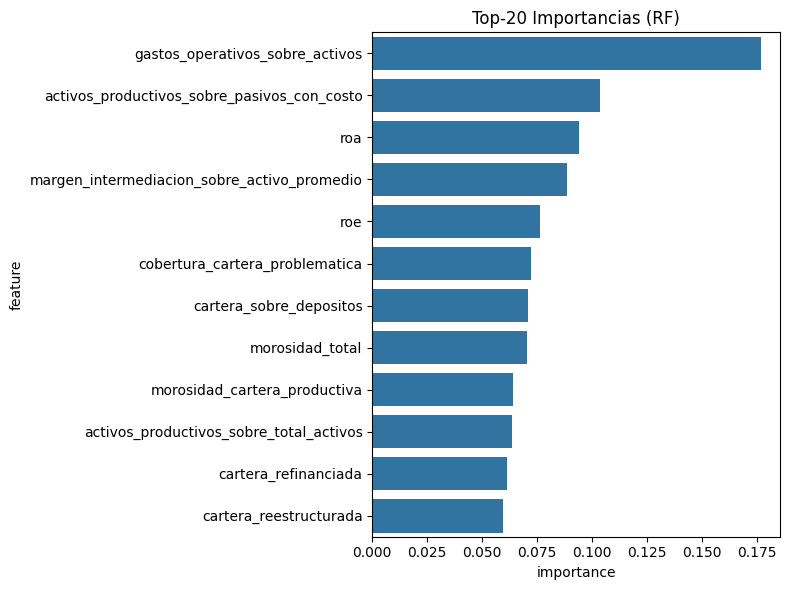

In [75]:
pipe_all = Pipeline(steps=[('prep', preprocess), ('clf', make_rf())])
pipe_all.fit(X_train, y_train)
rf = pipe_all.named_steps['clf']
try:
    importances = rf.feature_importances_
    imp_df = pd.DataFrame({'feature': feature_cols[:len(importances)], 'importance': importances})
    imp_df = imp_df.sort_values('importance', ascending=False).head(20)
    plt.figure(figsize=(8,6))
    sns.barplot(data=imp_df, x='importance', y='feature')
    plt.title('Top-20 Importancias (RF)')
    plt.tight_layout()
    plt.show()
except Exception as e:
    print('No se pudieron calcular importancias:', e)


## 2.4 Análisis y reporte
- Curvas desempeño vs `p` para cada método.
- Test estadístico (t-test pareado vs baseline por `p`).
- Efecto de `τ` y `k`.
- Discusión de errores frecuentes por clase.

### Notas sobre hiperparámetros y su efecto
- `ratio_labeled (p)`:
  - ↑p: más supervisión directa; mayor estabilidad.
  - ↓p: mayor dependencia de semisupervisado; mayor sensibilidad a ruido.
- `τ` en Self-Training:
  - ↑τ: acepta menos pseudoetiquetas (más precisión, menos recall).
  - ↓τ: acepta más pseudoetiquetas (más recall, riesgo de ruido).
- `k` en Label Spreading/Propagation:
  - ↑k: grafo denso, más suavizado; riesgo de sobre-propagación.
  - ↓k: grafo esparcido; puede fragmentar clases.
- `alpha` (Label Spreading):
  - ↑alpha: más peso a vecinos.
  - ↓alpha: más peso a etiquetas iniciales.
- Random Forest:
  - ↑n_estimators: menor varianza, mayor costo.
  - ↓max_depth: más sesgo; ↑max_depth: menor sesgo y posible sobreajuste.
- Preprocesamiento: imputación mediana + escalado + filtro de varianza.
  - El escalado es crítico para k-NN y t-SNE.